The purpose of this project is to produce a trained model that can predict a song rating for the tracks in my iTunes music library. 

The main steps are: 
1. Upload iTunes Music Library into an SQL database.
  * This process is outlined in the "iTunesSQL" document.
2. Use a set of already rated tracks to train and test 6 different models
3. Use the best model on my full iTunes library to rate my unrated songs.

I wanted to explore how well the models would predict rating based purely on a ratio of (Play_Count÷Skip_Count), so I generated a test dataset with ratings based on this ration plus some noise.

To generate the test dataset:
1. I uploaded a sample of about 300 songs.
2. I filled in missing Play_Count and Skip_Count with random integers.
3. To unrated songs, I assigned a Rating value based on 3 different ranges of the ratio Play_Count/Skip_Count.

Assignment of ratings based mainly on ratio of Play_Count / Skip_Count:
  To introduce some variability, I assigned the Ratings
   1. For Ratio <=0.5, Rating= [random sequence of 0 and 40]
   2. For 0.5 < Ratio < 2.0, Rating= [random sequence of 40 and 80]
   3. For Ratio >=2.0 , Rating= [random sequence of 80 and 120]
    
To train the models: 
1. I randomly split the test dataset into 80% training set and 20% validation set.
2. I provided the models with Play_Count, Ratio, Total_Time (song duration), and Rating.
3. Set up a 10-fold cross validation test harness.
4. Studied the confusion matrix and classification report. 

The trained model can now be used on my full iTunes Library!

In [1]:
# modifying the ast_note_interactivity kernel option to make
# jupyter pretty-print any variable or statement on it’s own line, so you can see the value of multiple statements at once.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# So that plots are displayed inline, "plt.show()" not needed.
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Importing needed libraries
# Check the versions of python and libraries
import sys
print('Python: {}'.format(sys.version))
# scipy
import scipy as sp
print('scipy: {}'.format(sp.__version__))
# numpy
import numpy as np
print('numpy: {}'.format(np.__version__))
# matplotlib
import matplotlib as mpl
print('matplotlib: {}'.format(mpl.__version__))
# pandas
import pandas as pd
print('pandas: {}'.format(pd.__version__))
# scikit-learn
import sklearn as sk
print('sklearn: {}'.format(sk.__version__))

import random
from pandas.tools.plotting import scatter_matrix
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

Python: 3.5.2 |Anaconda custom (x86_64)| (default, Jul  2 2016, 17:52:12) 
[GCC 4.2.1 Compatible Apple LLVM 4.2 (clang-425.0.28)]
scipy: 0.17.1
numpy: 1.11.1
matplotlib: 1.5.1
pandas: 0.19.0
sklearn: 0.18.1


In [3]:
#!/usr/bin/env python
from __future__ import print_function

import pymysql

conn = pymysql.connect(host='localhost',
                       port=3306,
                       user='root',
                       passwd='purple',
                       db='itdb')
                       
cur = conn.cursor()

cur.execute("SELECT Name, Artist FROM tracks")

# Inspect loaded cursor object
print(cur.description)
print(cur)
# for row in cur:
#     print(row)

# Read selections from table into a pandas dataframe.
df0 = pd.read_sql("SELECT Name, Artist, Total_Time, Skip_Count, \
                  Play_Count, Rating FROM tracks;", con=conn)
print("loaded dataframe from mysql records, df0.shape", df0.shape)

cur.close()
conn.close()

337

(('Name', 253, None, 1024, 1024, 0, True), ('Artist', 253, None, 1024, 1024, 0, True))
loaded dataframe from mysql records, df0.shape (337, 6)


In [4]:
# Keep df0 untouched, work with a copy named df1

df1=df0.copy()
#df1.iloc[::25,:]
#df1
# descriptions
print('describe'+'\n', df1.describe())

# describe
#            Total_Time  Skip_Count      Rating
# count     337.000000       337.0  337.000000
# mean   268934.605341         0.0   25.875371

describe
           Total_Time  Skip_Count      Rating
count     337.000000       337.0  337.000000
mean   268934.605341         0.0   25.875371
std     93574.224929         0.0   35.387597
min     36780.000000         0.0    0.000000
25%    220577.000000         0.0    0.000000
50%    259422.000000         0.0    0.000000
75%    317622.000000         0.0   80.000000
max    679314.000000         0.0   80.000000


In [5]:
# Raw data
# Training set
# How many records are there for each Rating level?
# class distribution
print('Rating - Count'+'\n',df1.groupby('Rating').size())

Rating - Count
 Rating
0     212
40     32
80     93
dtype: int64


In [6]:
# Filling in Artist. This is not relevant to the model training by Ratio,
# but it will be used for another project.

#Classical
df1.loc[df1['Artist'].str.contains('Classic|classic'),'Artist']='Classical'
df1.loc[df1['Name'].str.contains('Concierto'),'Artist']='Classical'
#df1[df1['Artist']==""] and df1['Name'].str.contains('Classic')]
df1.loc[(df1['Name'].str.contains('Classic|classic')) & 
        (df1['Artist']==""),"Artist"]='Classical'
#df1.loc[3:10]

# Laura Pausini
df1.loc[df1['Artist'].str.contains('Laura|laura|Pausini|pausini'),
        'Artist']='Laura Pausini'
df1.loc[df1['Name'].str.contains('Laura|laura|Pausini|pausini'),
        'Artist']='Laura Pausini'

#Heroes del Silencio
df1.loc[df1['Artist'].str.contains('Heroes|heroes|Silencio|silencio'),
        'Artist']='Heroes del Silencio'
df1.loc[df1['Name'].str.contains('Heroes|heroes|Silencio|silencio'),
        'Artist']='Heroes del Silencio'

df1['Artist'].unique()
#df1
#df1.loc[df1['Artist'].str.contains('Heroes')][1:10]
#df1.loc[df1['Artist'].str.contains('Gipsy')][1:10]

array(['Classical', '', 'Gipsy Kings', 'Heroes del Silencio',
       'Laura Pausini'], dtype=object)

In [7]:
# Fill in Play_Count
# random.randint(a,b) produces integers [a,b) Note, b not included. Documentation is wrong.
random.seed(124)
df1['Play_Count']=[random.randint(1,130) for x in range(0,337)]
#print('Index - Play Count'+'\n',df1['Play_Count'].head(5))
print('Description - Play_Count'+'\n', df1['Play_Count'].describe())
# Description - Play_Count
#  count    337.000000
# mean      65.741840
# std       39.740098

Description - Play_Count
 count    337.000000
mean      65.741840
std       39.740098
min        1.000000
25%       29.000000
50%       64.000000
75%      105.000000
max      130.000000
Name: Play_Count, dtype: float64


In [10]:
#Keep a copy
df1_0 = df1.copy()
# Restore df1 from copy
#df1=df1_0.copy()
print('Description - Play_Count'+'\n', df1['Play_Count'].describe())
# Description
#  count    337.000000
# mean      64.249258
# std       36.454843

Description - Play_Count
 count    337.000000
mean      65.741840
std       39.740098
min        1.000000
25%       29.000000
50%       64.000000
75%      105.000000
max      130.000000
Name: Play_Count, dtype: float64


In [11]:
# Fill in Skip_Count

len1=len( df1.loc[ ( df1['Artist']=="Classical")  ,'Skip_Count'] )
df1.loc[ ( df1['Artist']=="Classical")  ,'Skip_Count'] = \
[random.randint(50,120) for x in range(0,len1)]

len1=len( df1.loc[ ( df1['Artist']=="Laura Pausini")  ,'Skip_Count'] )
df1.loc[ ( df1['Artist']=="Laura Pausini")  ,'Skip_Count'] = \
[random.randint(10,80) for x in range(0,len1)]

len1=len( df1.loc[ ( df1['Artist']=="Heroes del Silencio")  ,'Skip_Count'] )
df1.loc[ ( df1['Artist']=="Heroes del Silencio")  ,'Skip_Count'] = \
[random.randint(10,30) for x in range(0,len1)]

len1=len( df1.loc[ ( df1['Artist']=="Gipsy Kings")  ,'Skip_Count'] )
df1.loc[ ( df1['Artist']=="Gipsy Kings")  ,'Skip_Count'] = \
[random.randint(30,80) for x in range(0,len1)]

len1=len( df1.loc[ ( df1['Artist']=="")  ,'Skip_Count'] )
df1.loc[ ( df1['Artist']=="")  ,'Skip_Count'] = \
[random.randint(40,80) for x in range(0,len1)]

In [12]:
list1=  np.log( df1['Play_Count']/df1['Skip_Count'] )
df1=df1.assign(Ratio=list1)
print('Description - Ratio'+'\n', df1['Ratio'].describe())
print('groupby(\'Rating\').size()'+'\n',df1.groupby('Rating').size())

Description - Ratio
 count    337.000000
mean       0.216706
std        1.144073
min       -3.891820
25%       -0.393043
50%        0.333144
75%        1.015921
max        2.509599
Name: Ratio, dtype: float64
groupby('Rating').size()
 Rating
0     212
40     32
80     93
dtype: int64


In [13]:
# Fill in Ratings, ratings are integer type
#df1['Rating'].unique() 
#df1_1 = df1.loc[((df1['Rating']==0) & (df1['Play_Count']/df1['Skip_Count'])<= 0.5 ),'Rating']
df1_1 = df1.loc[((df1['Play_Count']/df1['Skip_Count'])<= 0.5 ),'Rating']
len1=len( df1_1 )
randnums1=[randint(0,1)*40 for x in range(0,len1)]
df1.loc[ ( (df1['Play_Count']/df1['Skip_Count'])<= 0.5 ),'Rating'] = randnums1
print('Rating - Count'+'\n',df1.groupby('Rating').size())

Rating - Count
 Rating
0     234
40     25
80     78
dtype: int64


In [14]:
df1_3 = df1.loc[ ((df1['Play_Count']/df1['Skip_Count'])>= 3 ),'Rating']
len3=len( df1_3 )
randnums3=[random.randint(3,4)*40 for x in range(0,len3)]
df1.loc[ ( (df1['Play_Count']/df1['Skip_Count'])>= 3 ),'Rating']=120
print('Rating - Count'+'\n',df1.groupby('Rating').size())

Rating - Count
 Rating
0      193
40      18
80      49
120     77
dtype: int64


In [15]:
#To select subset based on these two criteria, enclose in parentheses each ratio, each condition, and the pair of conditions
df1_2 = df1.loc[(((df1['Play_Count']/df1['Skip_Count'])>= 0.5) & ((df1['Play_Count']/df1['Skip_Count'])<= 2 )),'Rating']
len2=len( df1_2 )
randnums2=[randint(1,2)*40 for x in range(0,len2)]
df1.loc[  (((df1['Play_Count']/df1['Skip_Count'])>= 0.5 ) & ((df1['Play_Count']/df1['Skip_Count'])<= 2 )),'Rating']=randnums2
print('Rating - Count'+'\n',df1.groupby('Rating').size())

Rating - Count
 Rating
0       95
40     157
80       8
120     77
dtype: int64


In [16]:
# Keep a copy
df_complete=df1.copy()
# Restore from copy
#df1=df_complete.copy()
# Keep only neccesary fields
df1=df1[['Total_Time','Play_Count','Ratio','Rating']]

Total_Time       Axes(0.125,0.547727;0.352273x0.352273)
Play_Count    Axes(0.547727,0.547727;0.352273x0.352273)
Ratio               Axes(0.125,0.125;0.352273x0.352273)
Rating           Axes(0.547727,0.125;0.352273x0.352273)
dtype: object

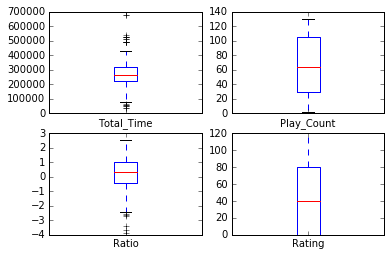

In [17]:
# box and whisker plots
df1.plot(kind='box', subplots=True, layout=(2,2), sharex=False, sharey=False)

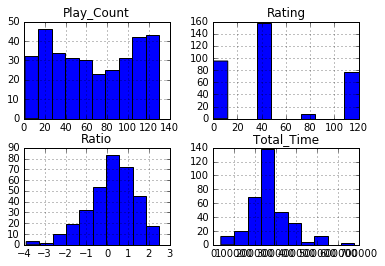

In [18]:
# Split into train and validation set

df1.hist();

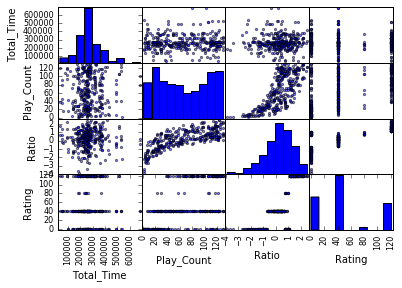

In [19]:
# scatter plot matrix
scatter_matrix(df1);

### Observations: 
    1. There aren't any outliers to worry about
    2. There is almost no correlation between Rating and Play_Count, as expected and desired.
    3. There is a slight negative correlation between Rating and Total_Time, 
    as expected, since I tend to get bored with very long songs.
    4. The correlation Play_Count and the Log of the Ratio is nonlinear, as expected.
    5. The correlation between Rating and Log of Ratio is weak but discernible, as expected and desired.

### Evaluate Some Algorithms  

Now it is time to create some models of the data and estimate their accuracy on unseen data.  
Here is what we are going to cover in this step:  
-Separate out a validation dataset.  
-Set-up the test harness to use 10-fold cross validation.  
-Build 5 different models to predict species from flower measurements  
-Select the best model.  

### Create a Validation Dataset  
We need to know that the model we created is any good. We want a concrete estimate of the accuracy of the best model on unseen data by evaluating it on actual unseen data.
  
We are going to hold back some data that the algorithms will not get to see and we will use this data to get a second and independent idea of how accurate the best model might actually be.

We split the loaded dataset into two, 80% of which we will use to train our models and 20% that we will hold back as a validation dataset.

In [20]:
# Split-out train and validation (or test) data subsets
array = df1.values
array

array([[  1.33041000e+05,   7.20000000e+01,   7.19734996e-02,
          4.00000000e+01],
       [  1.79957000e+05,   2.00000000e+00,  -3.70130197e+00,
          0.00000000e+00],
       [  2.23346000e+05,   4.60000000e+01,  -3.90866309e-01,
          4.00000000e+01],
       ..., 
       [  2.94817000e+05,   6.30000000e+01,   1.72842813e-01,
          4.00000000e+01],
       [  2.55529000e+05,   6.80000000e+01,   1.00063188e+00,
          0.00000000e+00],
       [  2.21440000e+05,   1.18000000e+02,   6.93147181e-01,
          4.00000000e+01]])

In [21]:
X = array[:,0:3]
Y = array[:,3] # col 3 is Rating
validation_size = 0.20
seed = 7
X_train, X_validation, Y_train, Y_validation = \
model_selection.train_test_split(X, Y, 
                                 test_size=validation_size, 
                                 random_state=seed)

### Test Harness  
We will use 10-fold cross validation to estimate accuracy.  

This will split our dataset into 10 parts (n_splits=10, in model.selection), train on 9 and test on 1 and repeat for 
all combinations of train-test splits.

In [22]:
# Test options and evaluation metric
seed = 7
scoring = 'accuracy'

We are using the metric of ‘accuracy‘ to evaluate models. This is a ratio of the number of correctly predicted instances in divided by the total number of instances in the dataset multiplied by 100 to give a percentage (e.g. 95% accurate). We will be using the scoring variable when we run build and evaluate each model next.  

### Build Models  
We don’t know which algorithms would be good on this problem or what configurations to use. We get an idea from the plots that some of the classes are partially linearly separable in some dimensions, so we are expecting generally good results.  

Let’s evaluate 6 different algorithms:  
* Logistic Regression (LR)  
* Linear Discriminant Analysis (LDA)  
* K-Nearest Neighbors (KNN)  
* Classification and Regression Trees (CART)  
* Gaussian Naive Bayes (NB)   
* Support Vector Machines (SVM)  

This is a good mixture of simple linear (LR and LDA), nonlinear (KNN, CART, NB and SVM) algorithms. We reset the random number seed before each run to ensure that the evaluation of each algorithm is performed using exactly the same data splits. It ensures the results are directly comparable.  

Let’s build and evaluate our five models:

In [23]:
# To bypass a warning about the LDA prior probabilities
# needing to be renormalized. 
import warnings    
warnings.filterwarnings('ignore', category=UserWarning) 

# Spot Check Algorithms
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
# evaluate each model in turn
results = []
names = []
print("Model - Mean - Std Dev")
for name, model in models:
	kfold = model_selection.KFold(n_splits=10, random_state=seed)
	cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())     
	print(msg)

Model - Mean - Std Dev
LR: 0.531909 (0.060330)
LDA: 0.836467 (0.052767)
KNN: 0.390313 (0.104919)
CART: 0.951852 (0.040741)
NB: 0.568946 (0.063400)
SVM: 0.465242 (0.094534)


http://www.psychstat.missouristate.edu/multibook/mlt03.htm

### Select Best Model  
We now have 6 models and accuracy estimations for each. We need to compare the models to each other and select the most accurate.  

We can see above that it looks like CART has the largest estimated accuracy score.  

We can also create a plot of the model evaluation results and compare the spread and the mean accuracy of each model. There is a population of accuracy measures for each algorithm because each algorithm was evaluated 10 times (10 fold cross validation).

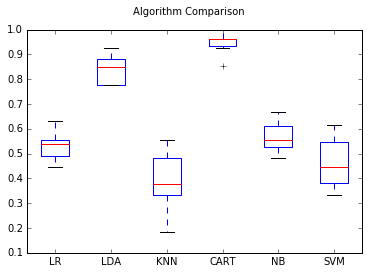

In [24]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)

ax.set_xticklabels(names); #outputs useless text

You can see that the box and whisker plots are squashed at the top of the range, with many samples achieving 100% accuracy.
Make Predictions
The CART algorithm was the most accurate model that we tested. Now we want to get an idea of the accuracy of the model on our validation set.
This will give us an independent final check on the accuracy of the best model. It is valuable to keep a validation set just in case you made a slip during training, such as overfitting to the training set or a data leak. Both will result in an overly optimistic result.
We can run the KNN model directly on the validation set and summarize the results as a final accuracy score, a confusion matrix and a classification report.

In [25]:
# Make predictions on validation dataset
# The best model was:  CART
best = DecisionTreeClassifier(); #CART
best.fit(X_train, Y_train);
predictions = best.predict(X_validation);
print("Confusion Matrix"+"\n", confusion_matrix(Y_validation, predictions));
print("Classification Report"+"\n",classification_report(Y_validation, predictions));
print("Accuracy score:", accuracy_score(Y_validation, predictions));

Confusion Matrix
 [[19  0  0  0]
 [ 0 35  0  0]
 [ 2  0  0  0]
 [ 0  0  0 12]]
Classification Report
              precision    recall  f1-score   support

        0.0       0.90      1.00      0.95        19
       40.0       1.00      1.00      1.00        35
       80.0       0.00      0.00      0.00         2
      120.0       1.00      1.00      1.00        12

avg / total       0.94      0.97      0.96        68

Accuracy score: 0.970588235294


We can see that the average F1-accuracy for all classes is 96%. This is a good result (given that the validation dataset was small and very noisy).  

### Confusion Matrix:  

The confusion matrix provides an indication of the errors made. en.wikipedia.org/wiki/Confusion_matrix  
For example: 
        Rating
class 0:   0  4 True positives, 6 False negatives, 2 False positives
class 1:  40 
class 2:  80 
class 3: 120


### Classification report

The classification report provides a breakdown of each class by precision, recall, f1-score and support

Precision - positive predictive value (fraction of positives that were true) TP/(TP+FP)

The f1-score is the harmonic mean of precision and recall; it is a measure of the test's accuracy. The scores corresponding to every class will tell you the accuracy of the classifier in classifying the data points in that particular class compared to all other classes. 

Accuracy - true predictive value (fraction of all samples correctly predicted true positive and true negative.) (TP+TN)/(P+N)

The support is the number of samples of the true responses that lie in that class.  (TP + FN)

F1-score - http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html  

Support - http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html  

### Interesting results

* For this small and noisy dataset, the 6 models gave very different accuracies
ranging from 28% (KNN) to 68% (CART).

* Providing Play_Count and Skip_Count gave a best accuracy of 32%.
Providing the ratio improved the best accuracy to 44%.

* Providing the ratio gave a best accuracy of 44%. 
Providing the log of the ratio improved the test accuracies to around 97%.